**Текст задания**

Есть 2 группы студентов одна их которых ходила на подготовительные курсы, другая нет.\
Нужно понять повлияло ли посещение курсов на балл студентов между группами.

## Загрузка и изучение данных

Импортируем необходимые для работы библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from tqdm.notebook import tqdm

Загрузим предоставленные датасеты

In [2]:
try:
    student_group = pd.read_csv('datasets/student_group.csv')
    student_before_score = pd.read_csv('datasets/student_before_score.csv')
    student_after_score = pd.read_csv('datasets/student_after_score.csv')
except:
    print('Не удалось загрузить датасеты')

Проверим, есть ли дубликаты id пользователей

In [3]:
student_group.student_id.duplicated().sum()

0

Дубликатов нет

Выведем на экран первые 5 строк каждого датасета

In [4]:
student_group.head()

,student_id,group
0,1,no_course
1,2,course
2,3,course
3,4,course
4,5,course


In [5]:
student_before_score.head()

,student_id,before_score
0,1,75
1,2,81
2,3,58
3,4,47
4,5,76


In [6]:
student_after_score.head()

,student_id,after_score
0,1,92
1,2,79
2,3,92
3,4,90
4,5,98


Предоставлены следующие данные:
- датафрейм `student_group` - принадлежность студента той или иной группе
- датаферйм `student_before_score` - баллы студентов в определенный период "до"
- датаферйм `student_after_score` - баллы студентов в определенный период "после"

Посмотрим на распределение студентов по наличию/отсутствию курсов в долевом соотеошении

In [7]:
student_group['group'].value_counts(normalize=True)

group
no_course    0.512
course       0.488
Name: proportion, dtype: float64

Студенты по наличию/отсутствию курсов распределены равномерно.

Для удобства соберем данные в один датафрейм

In [8]:
df = (
    student_group.merge(student_before_score, how='left', on='student_id')
                 .merge(student_after_score, how='left', on='student_id')
)

Выведем описание и информацию о датафрейме

In [9]:
df.describe()

,student_id,before_score,after_score
count,1000.000000,1000.00000,1000.000000
mean,500.500000,63.92500,84.623000
std,288.819436,14.59851,8.641154
min,1.000000,40.00000,70.000000
25%,250.750000,51.00000,77.000000
50%,500.500000,64.00000,85.000000
75%,750.250000,77.00000,92.000000
max,1000.000000,89.00000,99.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   student_id    1000 non-null   int64 
 1   group         1000 non-null   object
 2   before_score  1000 non-null   int64 
 3   after_score   1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


Пропуски отсутствуют, мы имеем полную информацию о всех студентах

## Исследовательский анализ данных

В рузультате анализа нам необходимо понять, понять повлияло ли посещение курсов на балл студентов между группами. В качестве метрики для оценки влияния примем разницу баллов в период "после" и "до" (обозначим как "прирост", может быть также отрицательным)

Вычислим столбец, который будет показывать величину прироста

In [11]:
df['growth'] = df['after_score'] - df['before_score']

In [12]:
df.head()

,student_id,group,before_score,after_score,growth
0,1,no_course,75,92,17
1,2,course,81,79,-2
2,3,course,58,92,34
3,4,course,47,90,43
4,5,course,76,98,22


Посмотрим на распределения переменных в разрезе групп

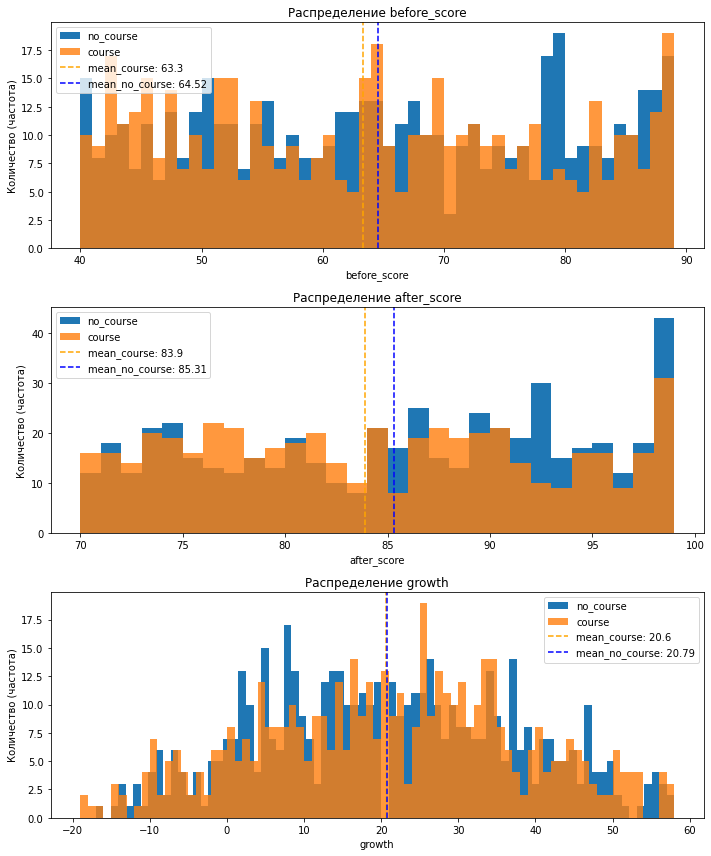

In [13]:
fig = plt.figure(figsize=(10,12))
names = ['before_score', 'after_score', 'growth']

for i, name in enumerate(names):
    ax = plt.subplot(3,1,i+1)
    bins = df[name].max() - df[name].min()
    mean_course = df.query('group == "course"')[name].mean()
    mean_no_course = df.query('group == "no_course"')[name].mean()
    
    ax.hist(data=df.query('group == "no_course"'), x=name, label='no_course', bins=bins)
    ax.hist(data=df.query('group == "course"'), x=name, label='course', alpha=0.8, bins=bins)

    ax.axvline(x=mean_course, color='orange', linestyle='--', label=f'mean_course: {mean_course.round(2)}')
    ax.axvline(x=mean_no_course, color='blue', linestyle='--', label=f'mean_no_course: {mean_no_course.round(2)}') 
    ax.set_xlabel(name)
    ax.set_ylabel('Количество (частота)')
    ax.set_title(f'Распределение {name}')
    ax.legend()

plt.tight_layout()
plt.show()

Исходя из графиков выше можно отметить следующее:
1. Распределение баллов в разрезе групп в период "до" равномерное.
2. Распределение баллов в разрезе групп в период "после" равномерное. Однако в диапазоне 91-98 баллов больше студентов из группы, не проходившей курсы.
3. Распределение прироста баллов имеет нормальную форму в обеих группах.

## Проверка гипотез

Определим, есть ли статистически значимые различия в средних для первых двух пунктов. Для проверки гипотез будем использовать permutation тест. Критический уровень статистической значимости *alpha примем равным 0,05.* Гипотезы сформулируем следующим образом:
- Н0 - средние двух групп (course и no_course) равны
- Н1 - средние двух групп не равны

*Равны ли средние количества баллов в группах в на момент "до"?*

In [14]:
n = 1000 # количество выборок для теста
base_diff = abs(df.query('group == "course"')['before_score'].mean() - df.query('group == "no_course"')['before_score'].mean())
# абсолютная разница средних между группами, с которой будем сравнивать разницу средних по выборке теста
result = []
alpha = 0.05 # критический уровень статзначимости

for _ in tqdm(range(n)):
    sample_a = df['before_score'].sample(n=len(df.query('group == "course"')), replace=True).mean()
    sample_b = df['before_score'].sample(n=len(df.query('group == "no_course"')), replace=True).mean()
    # разницу в количестве участников групп также учтем
    result.append(abs(sample_a - sample_b))
    
p_val = np.mean(result).round(3)
print('p-value:', p_val)

if p_val < alpha:
    print(f'Отвергаем нулевую гипотезу, p-value < alpha ({alpha})')
else:
    print(f'Нет оснований отвергнуть нулевую гипотезу, p-value > alpha ({alpha})')

  0%|          | 0/1000 [00:00<?, ?it/s]

p-value: 0.771
Нет оснований отвергнуть нулевую гипотезу, p-value > alpha (0.05)


Средние баллы двух групп на момент "до" равны

*Равны ли средние количества баллов в группах в на момент "после"?*

In [15]:
n = 1000 # количество выборок для теста
base_diff = abs(df.query('group == "course"')['after_score'].mean() - df.query('group == "no_course"')['after_score'].mean())
# абсолютная разница средних между группами, с которой будем сравнивать разницу средних по выборке теста
result = []
alpha = 0.05 # критический уровень статзначимости

for _ in tqdm(range(n)):
    sample_a = df['after_score'].sample(n=len(df.query('group == "course"')), replace=True).mean()
    sample_b = df['after_score'].sample(n=len(df.query('group == "no_course"')), replace=True).mean()
    # разницу в количестве участников групп также учтем
    result.append(abs(sample_a - sample_b))
    
p_val = np.mean(result).round(3)
print('p-value:', p_val)

if p_val < alpha:
    print(f'Отвергаем нулевую гипотезу, p-value < alpha ({alpha})')
else:
    print(f'Нет оснований отвергнуть нулевую гипотезу, p-value > alpha ({alpha})')

  0%|          | 0/1000 [00:00<?, ?it/s]

p-value: 0.441
Нет оснований отвергнуть нулевую гипотезу, p-value > alpha (0.05)


Средние баллы двух групп на момент "после" равны

Для сравнения пророста баллов по группам можем использовать t критерий, т.к. распределения прироста баллов имеют нормальную форму

Напишем функцию для сравнения групп с применением t критиерия, которая на вход будет принимать 2 выборки и уровень критерия статзначимости

In [16]:
def t_test_func(sample_a, sample_b, alpha):
    
    if stats.fligner(sample_a, sample_b)[1] < alpha:
        equal_var = False
    else:
        equal_var = True
    # проверку на равенство дисперсий выполним с помощью критерия Флигнера-Килина
        
    p_val = stats.ttest_ind(sample_a, sample_b, alternative='two-sided', equal_var=equal_var)[1]
    print('p-value:', p_val.round(3))
    
    if p_val < alpha:
        print(f'Отвергаем нулевую гипотезу, p-value < alpha ({alpha})')
    else:
        print(f'Нет оснований отвергнуть нулевую гипотезу, p-value > alpha ({alpha})')

*Проверим, равны ли средние значения приростов баллов по группам*

In [17]:
t_test_func(df.query('group == "course"')['growth'], df.query('group == "no_course"')['growth'], 0.05)

p-value: 0.861
Нет оснований отвергнуть нулевую гипотезу, p-value > alpha (0.05)


Приросты средних баллов двух групп на момент "после" равны

**Вывод:**
при рассмотрении двух выборок (проходивших курсы и не проходивших курсы студентов) не выявлено статистически значимых различий средних баллов. Однако, исходя из распределений баллов на момент "после" (см. графики распределений выше), целесообразно будет разбить студентов на категории по уровню образования ('low', 'medium', 'high') на момент "до" и посмотреть, есть ли статистически значимые различия в сриднем приросте баллов для каждой из групп.

## Проверка гипотез с разбивкой по категориям

Введем дополнительный столбец, который будет обозначать принадлежность студента определенной категории в зависимости от количества баллов на период "до". Поскольку распределения количества баллов на этот период равномерные, произведем разбиение на категории по 33 и 67 перцентилям переменной `before_score`

In [18]:
df['category'] = pd.qcut(df['before_score'], q=3, labels=['low', 'medium', 'high'])

In [19]:
df.head()

,student_id,group,before_score,after_score,growth,category
0,1,no_course,75,92,17,high
1,2,course,81,79,-2,high
2,3,course,58,92,34,medium
3,4,course,47,90,43,low
4,5,course,76,98,22,high


Проверим, как выполнилось разбиение. Для каждой категории выведем минимальный и максимальный балл, а также количество студентов в разрезе по группам

In [20]:
t = df.groupby(['category', 'group']).agg({'before_score':['min', 'max', 'count']}).reset_index()
t.columns = ['category', 'group', 'min', 'max', 'count']
t['share_in_cat'] = (t['count']/t.groupby('category')['count'].transform(sum)).round(2)

In [21]:
t

,category,group,min,max,count,share_in_cat
0,low,course,40,55,178,0.51
1,low,no_course,40,55,168,0.49
2,medium,course,56,72,163,0.49
3,medium,no_course,56,72,169,0.51
4,high,course,73,89,147,0.46
5,high,no_course,73,89,175,0.54


Доли каждой из групп во всех категориях приблизительно равны

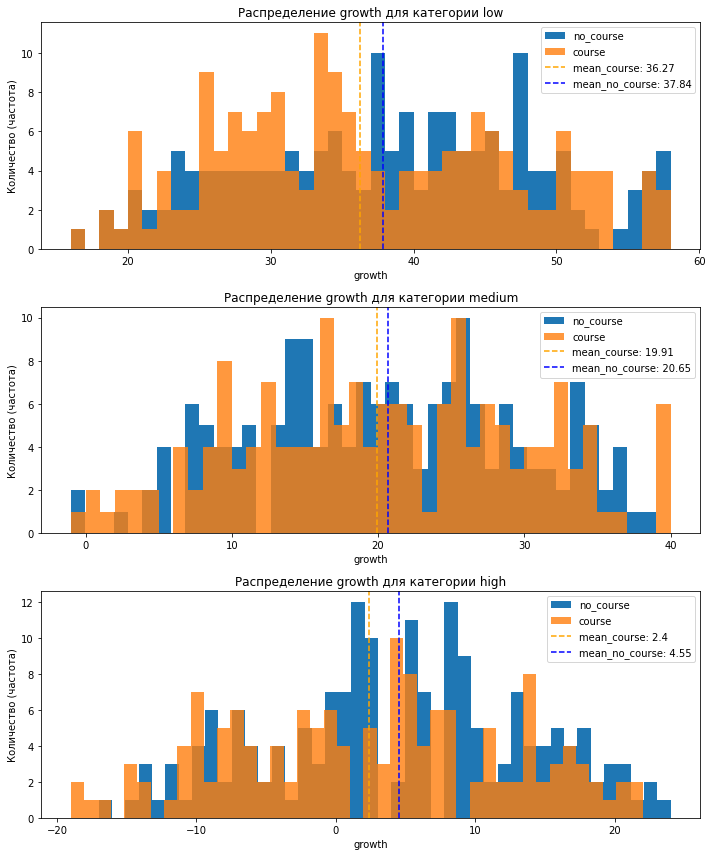

In [22]:
fig = plt.figure(figsize=(10,12))
names = ['low', 'medium', 'high']

for i, name in enumerate(names):
    ax = plt.subplot(3,1,i+1)
    bins = df[df['category'] == name]['growth'].max() - df[df['category'] == name]['growth'].min()
    mean_course = df[df['category'] == name].query('group == "course"')['growth'].mean()
    mean_no_course = df[df['category'] == name].query('group == "no_course"')['growth'].mean()
    
    ax.hist(data=df[df['category'] == name].query('group == "no_course"'), x='growth', label='no_course', bins=bins)
    ax.hist(data=df[df['category'] == name].query('group == "course"'), x='growth', label='course', alpha=0.8, bins=bins)

    ax.axvline(x=mean_course, color='orange', linestyle='--', label=f'mean_course: {mean_course.round(2)}')
    ax.axvline(x=mean_no_course, color='blue', linestyle='--', label=f'mean_no_course: {mean_no_course.round(2)}') 
    ax.set_xlabel('growth')
    ax.set_ylabel('Количество (частота)')
    ax.set_title(f'Распределение growth для категории {name}')
    ax.legend()

plt.tight_layout()
plt.show()

Все распределения имеют нормальную форму

In [23]:
for name in ['low', 'medium', 'high']: 
    print('Проверим гипотезу о равенстве среднего прироста баллов для категории студентов', name)
    t_test_func(df[df['category'] == name].query('group == "course"')['growth'], df[df['category'] == name].query('group == "no_course"')['growth'], 0.05)
    print('-'*15)

Проверим гипотезу о равенстве среднего прироста баллов для категории студентов low
p-value: 0.152
Нет оснований отвергнуть нулевую гипотезу, p-value > alpha (0.05)
---------------
Проверим гипотезу о равенстве среднего прироста баллов для категории студентов medium
p-value: 0.477
Нет оснований отвергнуть нулевую гипотезу, p-value > alpha (0.05)
---------------
Проверим гипотезу о равенстве среднего прироста баллов для категории студентов high
p-value: 0.048
Отвергаем нулевую гипотезу, p-value < alpha (0.05)
---------------


Только средний прирост баллов для категории студентов 'high' имеет статистически значимые различия между группами проходившими и не проходившими курсы. Однако в количественном значении он настолько мал (2.4 балла для проходивших курсы и 4.55 баллов для непроходивших курсы, что ими можно пренебречь.

## Общий вывод

В результате исследования на основании предоставленных данных установлено, что посещение подготовительных курсов не повлияло на балл студентов. Однако следует узнать, по какому критерию происходила разбивка студентов на группы (course и no_course). Возможно, в основном курсы брали студенты, менее уверенные в возможностях своей подготовки. Что и позволило им в конечном итоге получить балл на уровне студентов, которые не брали курсы. Для более точно оценки влияния подготовительных курсов на балл студента целесообразно дополнительно рассмотреть влияние иных параметров (например, способность к обучению и т.п.)